In [9]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Train a Mario-playing RL Agent
==============================

**Authors:** [Yuansong Feng](https://github.com/YuansongFeng), [Suraj
Subramanian](https://github.com/suraj813), [Howard
Wang](https://github.com/hw26), [Steven
Guo](https://github.com/GuoYuzhang).

This tutorial walks you through the fundamentals of Deep Reinforcement
Learning. At the end, you will implement an AI-powered Mario (using
[Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf)) that can
play the game by itself.

Although no prior knowledge of RL is necessary for this tutorial, you
can familiarize yourself with these RL
[concepts](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html),
and have this handy
[cheatsheet](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)
as your companion. The full code is available
[here](https://github.com/yuansongFeng/MadMario/).

![](https://pytorch.org/tutorials/_static/img/mario.gif)


``` {.sourceCode .bash}
%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0
```


In [10]:
%pip install gym-super-mario-bros==7.4.0
%pip install tensordict==0.3.0
%pip install torchrl==0.3.0
%pip install torchviz==0.0.2
%pip install torchvision
%pip install pyvirtualdisplay
!sudo apt-get install -y xvfb
!apt install libglu1-mesa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


'sudo' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os
from torchviz import make_dot

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

RL Definitions
==============

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The set of
all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The set
of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to Agent.
It is what drives the Agent to learn and to change its future action. An
aggregation of rewards over multiple time steps is called **Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected return
if you start in state $s$, take an arbitrary action $a$, and then for
each future time step take the action that maximizes returns. $Q$ can be
said to stand for the "quality" of the action in a state. We try to
approximate this function.


Environment
===========

Initialize Environment
----------------------

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.


In [12]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


Preprocess Environment
======================

Environment data is returned to the agent in `next_state`. As you saw
above, each state is represented by a `[3, 240, 256]` size array. Often
that is more information than our agent needs; for instance, Mario's
actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

`GrayScaleObservation` is a common wrapper to transform an RGB image to
grayscale; doing so reduces the size of the state representation without
losing useful information. Now the size of each state: `[1, 240, 256]`

`ResizeObservation` downsamples each observation into a square image.
New size: `[1, 84, 84]`

`SkipFrame` is a custom wrapper that inherits from `gym.Wrapper` and
implements the `step()` function. Because consecutive frames don't vary
much, we can skip n-intermediate frames without losing much information.
The n-th frame aggregates rewards accumulated over each skipped frame.

`FrameStack` is a wrapper that allows us to squash consecutive frames of
the environment into a single observation point to feed to our learning
model. This way, we can identify if Mario was landing or jumping based
on the direction of his movement in the previous several frames.


In [13]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size `[4, 84, 84]`.

![](https://pytorch.org/tutorials/_static/img/mario_env.png)


Agent
=====

We create a class `Mario` to represent our agent in the game. Mario
should be able to:

-   **Act** according to the optimal action policy based on the current
    state (of the environment).
-   **Remember** experiences. Experience = (current state, current
    action, reward, next state). Mario *caches* and later *recalls* his
    experiences to update his action policy.
-   **Learn** a better action policy over time


In [14]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario's parameters and
define his functions.


Act
===

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of `self.exploration_rate`; when
he chooses to exploit, he relies on `MarioNet` (implemented in `Learn`
section) to provide the most optimal action.


In [15]:
import mmap
import torch
import numpy as np

class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Mario's DNN to predict the most optimal action
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

        # Assuming these are correctly initialized elsewhere in the code
        self.memory = None  # Placeholder; adjust as needed
        self.batch_size = 32  # Example value
        self.gamma = 0.99  # Example value
        self.optimizer = torch.optim.Adam(self.net.parameters())  # Adjust as needed
        self.loss_fn = torch.nn.SmoothL1Loss()  # Adjust as needed
        self.burnin = 1e4  # Example value
        self.learn_every = 3  # Example value
        self.sync_every = 1e3  # Example value

    def act(self, state):
        """
        Given a state, choose an epsilon-greedy action and update value of step.

        Inputs:
        state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
        Outputs:
        ``action_idx`` (``int``): An integer representing which action Mario will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # Decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # Increment step
        self.curr_step += 1
        return action_idx


Cache and Recall
================

These two functions serve as Mario's "memory" process.

`cache()`: Each time Mario performs an action, he stores the
`experience` to his memory. His experience includes the current *state*,
*action* performed, *reward* from the action, the *next state*, and
whether the game is *done*.

`recall()`: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.


In [16]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

Learn
=====

Mario uses the [DDQN algorithm](https://arxiv.org/pdf/1509.06461) under
the hood. DDQN uses two ConvNets - $Q_{online}$ and $Q_{target}$ - that
independently approximate the optimal action-value function.

In our implementation, we share feature generator `features` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC classifiers for
each. $\theta_{target}$ (the parameters of $Q_{target}$) is frozen to
prevent updating by backprop. Instead, it is periodically synced with
$\theta_{online}$ (more on this later).

Neural Network
--------------


In [17]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

TD Estimate & TD Target
=======================

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state $s$

$${TD}_e = Q_{online}^*(s,a)$$

**TD Target** - aggregation of current reward and the estimated $Q^*$ in
the next state $s'$

$$a' = argmax_{a} Q_{online}(s', a)$$

$${TD}_t = r + \gamma Q_{target}^*(s',a')$$

Because we don't know what next action $a'$ will be, we use the action
$a'$ maximizes $Q_{online}$ in the next state $s'$.

Notice we use the
[\@torch.no\_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)
decorator on `td_target()` to disable gradient calculations here
(because we don't need to backpropagate on $\theta_{target}$).


In [18]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

Updating the model
==================

As Mario samples inputs from his replay buffer, we compute $TD_t$ and
$TD_e$ and backpropagate this loss down $Q_{online}$ to update its
parameters $\theta_{online}$ ($\alpha$ is the learning rate `lr` passed
to the `optimizer`)

$$\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)$$

$\theta_{target}$ does not update through backpropagation. Instead, we
periodically copy $\theta_{online}$ to $\theta_{target}$

$$\theta_{target} \leftarrow \theta_{online}$$


In [19]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

Save checkpoint
===============


In [20]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

              # Get the actual input to the model
        state = env.reset()
        state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
        state = torch.tensor(state, device=self.device).unsqueeze(0)

        # Visualize the model with the actual input and save it
        y = self.net(state, model='online')
        make_dot(y.mean(), params=dict(self.net.named_parameters())).render(str(save_path), format="jpg")
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

Putting it all together
=======================


In [21]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

Logging
=======


In [22]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

Let's play!
===========

In this example we run the training loop for 40 episodes, but for Mario
to truly learn the ways of his world, we suggest running the loop for at
least 40,000 episodes!


Using CUDA: False

Episode 0 - Step 203 - Epsilon 0.9999492512814088 - Mean Reward 727.0 - Mean Length 203.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 2.051 - Time 2024-09-17T22:40:07
Episode 3 - Step 1261 - Epsilon 0.9996847996466214 - Mean Reward 798.25 - Mean Length 315.25 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 7.91 - Time 2024-09-17T22:40:15


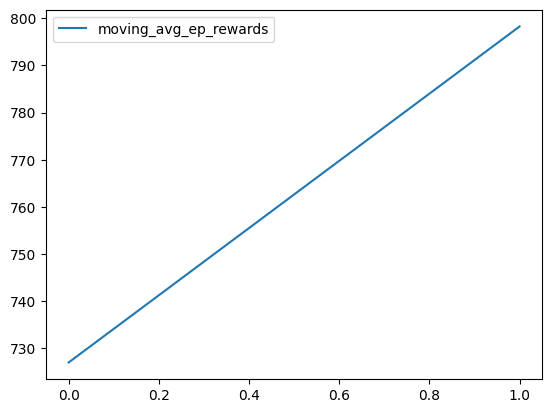

In [25]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 4
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()


    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

In [33]:
import torch
import gym

def evaluate_model(env, model, num_episodes=10):
    """
    Evaluate the model by running it in the environment for a given number of episodes.

    Args:
    env: The environment to run the model in, with render_mode set to 'human'.
    model: The trained model to evaluate.
    num_episodes: Number of episodes to run for evaluation.

    Returns:
    None
    """
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Extract observation if state is a tuple (e.g., (observation, info))
            if isinstance(state, tuple):
                observation = state[0]  # Typically the first element is the observation
            else:
                observation = state

            # Convert observation to array format suitable for the model
            observation = observation.__array__()
            observation = torch.tensor(observation, device=model.device).unsqueeze(0)

            with torch.no_grad():
                action_values = model.net(observation, model="online")
                action_idx = torch.argmax(action_values, axis=1).item()

            # Step through the environment
            next_state, reward, done, trunc, info = env.step(action_idx)
            total_reward += reward
            state = next_state

            # Render the environment in human mode
            env.render()

        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    env.close()



In [2]:
evaluate_model(env, mario)

NameError: name 'evaluate_model' is not defined